In [6]:
pip install tqdm

SyntaxError: invalid syntax (<ipython-input-6-9bb7009cee5c>, line 1)

In [3]:
import os
import tensorflow
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Reshape, Concatenate, Activation
import tensorflow.keras.backend as K
from AnchorBoxes import AnchorBoxes
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from SSDLoss import SSDLoss
from get_data import get_data
from scipy.io import loadmat
import pandas as pd
from ssd_input_encoder import SSDInputEncoder
import ssd_output_decoder as decoder_op
from DataGenerator import DataGenerator
import math
from PIL import Image
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image
import cv2 
from IPython.display import display

ModuleNotFoundError: No module named 'keras_vggface'

In [2]:
img_height = 240# Height of the input images
img_width = 240 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 1 # Number of positive classes
scales = [0.01, 0.16, 0.32, 0.64, 0.28, 2.56, 5.12] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [1.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

def get_model(image_size = (240,240,3),
                n_classes=2,
                mode='training',
                l2_regularization=0.0001,
                min_scale=0.1,
                max_scale=0.9,
                scales=[1,16, 32, 64, 128, 256, 512],
                aspect_ratios_global=[1.0],
                aspect_ratios_per_layer=None,
                two_boxes_for_ar1=True,
                steps=None,
                offsets=None,
                clip_boxes=False,
                variances=[1.0, 1.0, 1.0, 1.0],
                coords='minmax',
                normalize_coords=True,
                subtract_mean=None,
                divide_by_stddev=None,
                swap_channels=False,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False):
    n_predictor_layers = 6
    l2_reg = l2_regularization  # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError(
            "`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError(
                "It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(
                    n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers + 1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(
                n_predictor_layers + 1, len(scales)))
    else:  # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers + 1)

    if len(variances) != 4:  # We need one variance value for each of the four box coordinates
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")


    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1)  # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else:  # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    base_network = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(240,240, 3))

    base_network.trainable = False

    c3_output, c4_output, c5_output = [
        base_network.get_layer(layer_name).output
        for layer_name in ["block3_conv3", "block4_conv3", "block5_conv3"]]

    vgg_16_output = base_network.output

    fc6 = layers.Conv2D(1024, 3, padding='same',activation='relu')(vgg_16_output)

    fc7 = layers.Conv2D(1024, 1, padding='same', activation='relu')(fc6) #detection layer

    conv6_1 = layers.Conv2D(256, 1, activation='relu')(fc7)

    conv6_2 = layers.Conv2D(512, 3, strides=2, activation='relu')(conv6_1) #detection layer

    conv7_1 = layers.Conv2D(128, 1, activation='relu')(conv6_2)

    conv7_2 = layers.Conv2D(256, 3, strides=2, activation='relu')(conv7_1) #detection layer

    normalized_c3 = Lambda(lambda t: K.l2_normalize(10 * t, axis=[1, 2, 3]))(c3_output)

    normalized_c4 = Lambda(lambda t: K.l2_normalize(8 * t, axis=[1, 2, 3]))(c4_output)

    normalized_c5 = Lambda(lambda t: K.l2_normalize(5 * t, axis=[1, 2, 3]))(c5_output)

    # p1 = layers.Conv2D(6, 3, activation='relu')(normalized_c3)  # units = Ns+4

    # p2 = layers.Conv2D(6, 3, activation='relu')(normalized_c4)

    # p3 = layers.Conv2D(6, 3, activation='relu')(normalized_c5)

    # p4 = layers.Conv2D(6, 3, activation='relu')(fc7)

    # p5 = layers.Conv2D(6, 3, activation='relu')(conv6_2)

    # p6 = layers.Conv2D(6, 3, activation='relu')(conv7_2)

    classes1 = layers.Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                      kernel_regularizer=l2(l2_reg), name='classes1')(normalized_c3)
    classes2 = layers.Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same",
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(l2_reg), name='classes2')(normalized_c4)
    classes3 = layers.Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same",
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(l2_reg), name='classes3')(normalized_c5)
    classes4 = layers.Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same",
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(l2_reg), name='classes4')(fc7)
    classes5 = layers.Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same",
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(l2_reg), name='classes5')(conv6_2)
    classes6 = layers.Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same",
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(l2_reg), name='classes6')(conv7_2)

    boxes1 = layers.Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_reg), name='boxes1')(normalized_c3)
    boxes2 = layers.Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_reg), name='boxes2')(normalized_c4)
    boxes3 = layers.Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_reg), name='boxes3')(normalized_c5)
    boxes4 = layers.Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_reg), name='boxes4')(fc7)
    boxes5 = layers.Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_reg), name='boxes5')(conv6_2)
    boxes6 = layers.Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_reg), name='boxes6')(conv7_2)


    anchors1 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios_global,
                           two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords,
                           name='anchors1')(boxes1)
    anchors2 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1],
                           aspect_ratios=aspect_ratios_global,two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords,
                           name='anchors2')(boxes2)
    anchors3 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1],aspect_ratios=aspect_ratios_global, two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords,
                           name='anchors3')(boxes3)
    anchors4 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1],
                           aspect_ratios=aspect_ratios_global, two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords,
                           name='anchors4')(boxes4)
    anchors5 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1],
                           aspect_ratios=aspect_ratios_global,two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords,
                           name='anchors5')(boxes5)
    anchors6 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1],
                           aspect_ratios=aspect_ratios_global, two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords,
                           name='anchors6')(boxes6)


    classes1_reshaped = Reshape((-1, n_classes), name='classes1_reshape')(classes1)
    classes2_reshaped = Reshape((-1, n_classes), name='classes2_reshape')(classes2)
    classes3_reshaped = Reshape((-1, n_classes), name='classes3_reshape')(classes3)
    classes4_reshaped = Reshape((-1, n_classes), name='classes4_reshape')(classes4)
    classes5_reshaped = Reshape((-1, n_classes), name='classes5_reshape')(classes5)
    classes6_reshaped = Reshape((-1, n_classes), name='classes6_reshape')(classes6)


    # Reshape the box coordinate predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, 4)`
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    boxes1_reshaped = Reshape((-1, 4), name='boxes1_reshape')(boxes1)
    boxes2_reshaped = Reshape((-1, 4), name='boxes2_reshape')(boxes2)
    boxes3_reshaped = Reshape((-1, 4), name='boxes3_reshape')(boxes3)
    boxes4_reshaped = Reshape((-1, 4), name='boxes4_reshape')(boxes4)
    boxes5_reshaped = Reshape((-1, 4), name='boxes5_reshape')(boxes5)
    boxes6_reshaped = Reshape((-1, 4), name='boxes6_reshape')(boxes6)

    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    anchors1_reshaped = Reshape((-1, 8), name='anchors1_reshape')(anchors1)
    anchors2_reshaped = Reshape((-1, 8), name='anchors2_reshape')(anchors2)
    anchors3_reshaped = Reshape((-1, 8), name='anchors3_reshape')(anchors3)
    anchors4_reshaped = Reshape((-1, 8), name='anchors4_reshape')(anchors4)
    anchors5_reshaped = Reshape((-1, 8), name='anchors5_reshape')(anchors5)
    anchors6_reshaped = Reshape((-1, 8), name='anchors6_reshape')(anchors6)


    classes_concat = Concatenate(axis=1, name='classes_concat')([classes1_reshaped,
                                                                 classes2_reshaped,
                                                                 classes3_reshaped,
                                                                 classes4_reshaped,
                                                                 classes5_reshaped,
                                                                 classes6_reshaped])

    # Output shape of `boxes_concat`: (batch, n_boxes_total, 4)
    boxes_concat = Concatenate(axis=1, name='boxes_concat')([boxes1_reshaped,
                                                             boxes2_reshaped,
                                                             boxes3_reshaped,
                                                             boxes4_reshaped,
                                                             boxes5_reshaped,
                                                             boxes6_reshaped])

    # Output shape of `anchors_concat`: (batch, n_boxes_total, 8)
    anchors_concat = Concatenate(axis=1, name='anchors_concat')([anchors1_reshaped,
                                                                 anchors2_reshaped,
                                                                 anchors3_reshaped,
                                                                 anchors4_reshaped,
                                                                 anchors5_reshaped,
                                                                 anchors6_reshaped])


    classes_softmax = Activation('softmax', name='classes_softmax')(classes_concat)

    # Concatenate the class and box coordinate predictions and the anchors to one large predictions tensor
    # Output shape of `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([classes_softmax, boxes_concat, anchors_concat])

    model = Model(inputs=base_network.inputs, outputs=predictions)
    return model

print("before model")
model = get_model()
print("getting summary")
print(model.summary())

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

model.load_weights("model_weights1_epoch_155.h5")

before model
[2020-12-12 21:18:26.603 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:12470 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2020-12-12 21:18:26.832 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:12470 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
getting summary
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 240, 240, 64) 1792        input_1[0][0]                    
_____________________________________________________________________________________

In [6]:
test_filenames = os.listdir("00")
faces_list = []

for filename in test_filenames:
    try:
        test_img_original = cv2.imread(os.path.join("00",filename))

        test_img = Image.fromarray(test_img_original)
        test_img = test_img.resize((240,240))

        test_img = np.asarray(test_img)

        test_img_test = np.expand_dims(test_img,axis=0)

        y_pred = model.predict(test_img_test)

        y_pred_decoded = decoder_op.decode_detections_fast(y_pred,
                                           confidence_thresh=0.5,
                                           iou_threshold=0.35,
                                           top_k=400,
                                           normalize_coords=True,
                                           input_coords='minmax',
                                           img_height=img_height,
                                           img_width=img_width)


    #Extracting the faces 
        if len(y_pred_decoded[0]) != 0:
            boxes = np.array(y_pred_decoded[0])
            boxes = boxes[:,[2,3,4,5]]
            face_boxes = []
            for i in range(boxes.shape[0]):
                count = 0
                temp = boxes[i]
                for j in temp:
                    if j > test_img_original.shape[0] or j > j > test_img_original.shape[1]:
                        count+=1

                if count == 0:
                    face_boxes.append(temp)

            faces_boxes=np.array(face_boxes)
            if len(faces_boxes)!= 0:
                for i in range(faces_boxes.shape[0]):
                    xmin = int(faces_boxes[i][0])
                    ymin = int(faces_boxes[i][1])
                    xmax = int(faces_boxes[i][2])
                    ymax = int(faces_boxes[i][3])
                    try:

                        rect = np.copy(test_img_original[ymin:ymax,xmin:xmax])
                        face = Image.fromarray(rect)
                        face = face.resize((240,240))
                        faces_list.append(np.array(face))

                    except:
                        pass
        


    except:
        pass
                


        
print(len(faces_list))    

108


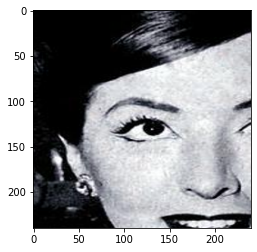

In [7]:
#Sample Faces cropped from imdb wiki dataset
plt.imshow(faces_list[0])


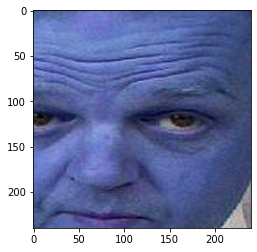

In [8]:
plt.imshow(faces_list[1])

In [9]:
#To run the recognizer on 20 of these images
test_faces = faces_list[:50]
test_faces = np.array(test_faces)
print(test_faces.shape)

(50, 240, 240, 3)


In [10]:
#Build the Recognition model
face_model = VGGFace(model='resnet50',input_shape=(240,240,3))
face_model.summary()


Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 120, 120, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 120, 120, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 120, 120, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

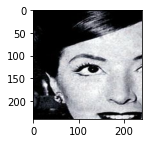

"b' Agustina_Cherri': 0.911%"

"b' Coraima_Torres': 0.865%"

"b' Carman_Lee': 0.789%"

"b' Samantha_Eggar': 0.764%"

"b' Rika_Zara\\xc3\\xaf': 0.755%"

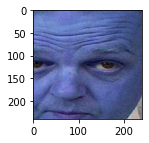

"b' Jack_Bauer': 11.328%"

"b' John_C._Reilly': 10.744%"

"b' Gigi_DAlessio': 5.332%"

"b' Adam_Housley': 5.235%"

"b' Ellie_Simmonds': 4.921%"

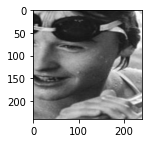

"b' Ekaterina_Makarova': 12.794%"

"b' Emma_Moffatt': 3.405%"

"b' Cara_Dillon': 2.299%"

"b' Fionnuala_Britton': 1.760%"

"b' Allison_Mack': 1.703%"

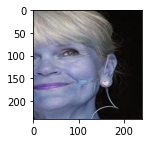

"b' Zo\\xc3\\xab_Ball': 13.671%"

"b' Martha_Coakley': 8.274%"

"b' Ma\\xc5\\x82gorzata_Braunek': 4.157%"

"b' Sherri_Coale': 3.161%"

"b' Tjitske_Reidinga': 2.287%"

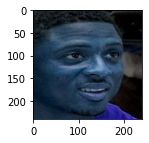

"b' Dbanj': 21.862%"

"b' Colin_Kazim-Richards': 11.353%"

"b' Sidney_Sam': 5.532%"

"b' Brandon_Knight': 4.620%"

"b' Kenenisa_Bekele': 4.171%"

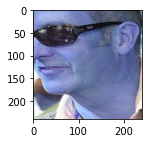

"b' Dag_Otto_Lauritzen': 5.213%"

"b' Mikael_Damberg': 2.394%"

"b' Herbert_Gr\\xc3\\xb6nemeyer': 1.469%"

"b' Greg_Proops': 1.366%"

"b' Jimi_Jamison': 1.360%"

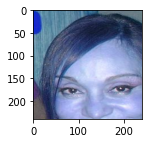

"b' Grace_Hightower': 3.377%"

"b' Loren_Legarda': 2.624%"

"b' Carmit_Bachar': 2.376%"

"b' Beate_Merk': 1.701%"

"b' Valerie_Harper': 0.798%"

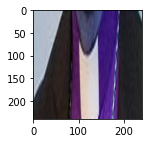

"b' Natsumi_Matsubara': 0.435%"

"b' Bob_Beckel': 0.368%"

"b' Venke_Knutson': 0.281%"

"b' Nurul_Izzah_Anwar': 0.275%"

"b' Peter_Altmaier': 0.222%"

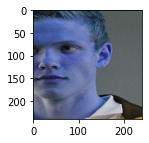

"b' Fabian_Hamb\\xc3\\xbcchen': 20.083%"

"b' Jonas_Jerebko': 4.521%"

"b' Marcell_Jansen': 4.460%"

"b' Koen_Verweij': 2.663%"

"b' Max_Riemelt': 2.051%"

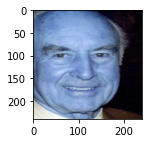

"b' Jerry_Brown': 27.103%"

"b' Jeff_Stelling': 13.623%"

"b' Dominique_Bussereau': 6.516%"

"b' Quentin_L._Cook': 6.128%"

"b' Helmut_Kohl': 6.051%"

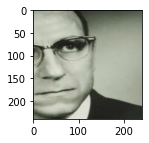

"b' Zbigniew_Zamachowski': 3.389%"

"b' Moacyr_Franco': 2.661%"

"b' Sacinandana_Swami': 2.426%"

"b' Jayapataka_Swami': 2.052%"

"b' Christoph_Sch\\xc3\\xb6nborn': 1.859%"

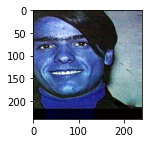

"b' Esteban_Guti\\xc3\\xa9rrez': 31.984%"

"b' Nicolas_Kiefer': 4.628%"

"b' Sammy_Adams': 3.548%"

"b' Juan_Pedro_Lanzani': 2.699%"

"b' Andrey_Amador': 1.555%"

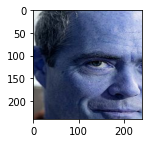

"b' Pablo_Bengoechea': 17.331%"

"b' Henry_Rollins': 8.626%"

"b' Johannes_Remmel': 4.895%"

"b' Zvezdan_Terzi\\xc4\\x87': 4.791%"

"b' Yair_Lapid': 3.895%"

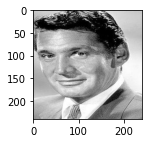

"b' Alejandro_Sanz': 11.309%"

"b' Jeff_Timmons': 7.082%"

"b' Dayanand_Shetty': 4.219%"

"b' Martin_Kaymer': 3.452%"

"b' Ronnie_Ortiz-Magro': 2.897%"

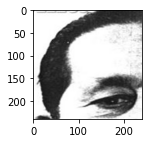

"b' Burning_Spear': 0.407%"

"b' Karl_Denson': 0.224%"

"b' Isaac_Hayes': 0.173%"

"b' Gurmeet_Ram_Rahim_Singh': 0.172%"

"b' Demis_Roussos': 0.170%"

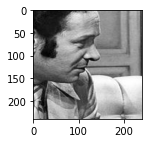

"b' Frank_Whaley': 5.544%"

"b' Harry_Judd': 5.192%"

"b' Ville_Haapasalo': 3.844%"

"b' Jeff_Corwin': 2.961%"

"b' Seamus_Dever': 2.761%"

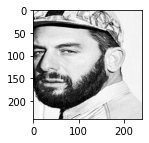

"b' Mohamed_Hamaki': 3.183%"

"b' Neri_Marcor\\xc3\\xa8': 2.868%"

"b' Roman_Reigns': 2.774%"

"b' Ozan_Do\\xc4\\x9fulu': 2.743%"

"b' DJ_Tarkan': 2.576%"

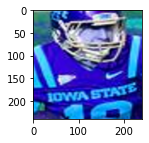

"b' Ted_Ligety': 0.399%"

"b' Andreas_Birnbacher': 0.282%"

"b' Christof_Innerhofer': 0.278%"

"b' Vesna_Fabjan': 0.208%"

"b' Alexandre_Bilodeau': 0.178%"

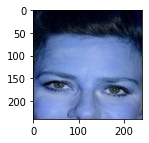

"b' Marina_Fois': 21.890%"

"b' Deborah_Hutton': 6.154%"

"b' Agata_Kulesza': 4.667%"

"b' Rados\\xc5\\x82aw_Majdan': 2.409%"

"b' Dot_Jones': 2.047%"

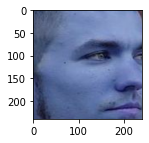

"b' Nicholas_Hoult': 52.659%"

"b' Daniel_Schuhmacher': 1.280%"

"b' Adam_Sztaba': 1.210%"

"b' Immortal_Technique': 0.760%"

"b' David_Garrett': 0.647%"

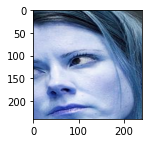

"b' Deborah_Kara_Unger': 6.477%"

"b' Claire_Danes': 2.674%"

"b' Katarzyna_Piter': 2.268%"

"b' Jackie_Gayda': 2.266%"

"b' Laura_Croft': 2.205%"

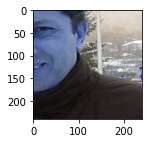

"b' Ad\\xc3\\xadlson_Batista': 1.125%"

"b' Mario_Pergolini': 0.662%"

"b' Trevor_Rabin': 0.607%"

"b' Carlos_Ocariz': 0.585%"

"b' Carlos_Mortensen': 0.515%"

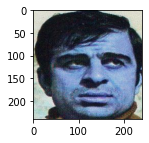

"b' Jaz_Coleman': 31.843%"

"b' Steven_Van_Zandt': 5.811%"

"b' Joe_Calzaghe': 5.597%"

"b' Claude_Barzotti': 5.544%"

"b' Joe_Dassin': 3.550%"

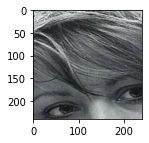

"b' Damian_Charles_Hurley': 0.716%"

"b' Zabou_Breitman': 0.449%"

"b' Selah_Sue': 0.370%"

"b' Alex_Gaskarth': 0.295%"

"b' Vica_Kerekes': 0.268%"

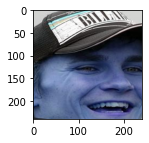

"b' Andy_Roddick': 9.360%"

"b' Mika_Kojonkoski': 6.312%"

"b' Carolina_Dieckmann': 4.708%"

"b' Piotr_\\xc5\\xbby\\xc5\\x82a': 4.137%"

"b' Leo\\xc5\\xa1_Mare\\xc5\\xa1': 4.120%"

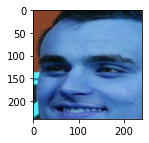

"b' Charlie_Simpson': 9.203%"

"b' Mauricio_Islas': 7.518%"

"b' Gonzalo_Heredia': 6.300%"

"b' Abhay_Deol': 4.893%"

"b' Rodrigo_Pimp\\xc3\\xa3o': 3.934%"

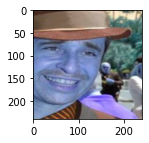

"b' S\\xc3\\xa9rgio_Marone': 4.282%"

"b' Yannick_Noah': 4.122%"

"b' Joost_Luiten': 3.194%"

"b' Thomas_Voeckler': 3.096%"

"b' Sandy_Koufax': 2.671%"

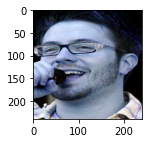

"b' Danny_Gokey': 77.990%"

"b' Avraham_Fried': 2.631%"

"b' Luciano_Pereyra': 2.326%"

"b' Joko_Anwar': 1.191%"

"b' The_Tallest_Man_on_Earth': 0.780%"

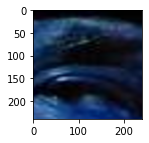

"b' Karekin_II': 0.385%"

"b' Moussa_Dadis_Camara': 0.313%"

"b' Little_Freddie_King': 0.298%"

"b' Almir_Sater': 0.217%"

"b' Stevie_Ray': 0.211%"

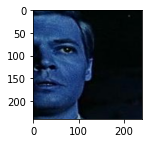

"b' Gary_Numan': 4.430%"

"b' Roger_Cicero': 3.483%"

"b' Lauris_Reiniks': 3.136%"

"b' Sam_Champion': 2.040%"

"b' Ly_Jonaitis': 1.509%"

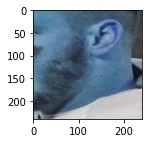

"b' Rytmus': 0.458%"

"b' Bhakti_Charu_Swami': 0.320%"

"b' Miguel_Cotto': 0.240%"

"b' Artur_Szpilka': 0.220%"

"b' Nazia_Iqbal': 0.217%"

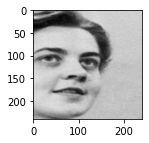

"b' Rosanne_Cash': 11.869%"

"b' Israel_Broussard': 2.620%"

"b' Sean_Kingston': 2.251%"

"b' Am\\xc3\\xa9lie_Nothomb': 2.092%"

"b' Rosie_ODonnell': 1.982%"

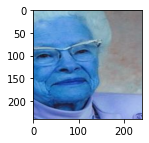

"b' Paula_Risikko': 10.571%"

"b' Odilo_Scherer': 9.153%"

"b' Du\\xc5\\xa1an_Ivkovi\\xc4\\x87': 8.321%"

"b' Carlos_Arthur_Nuzman': 4.364%"

"b' Heinz_Rudolf_Kunze': 3.953%"

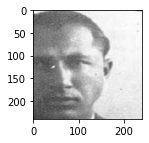

"b' Russell_Means': 14.531%"

"b' Albert_Sosnowski': 6.606%"

"b' Ricardo_Mayorga': 2.739%"

"b' Adam_Sztaba': 2.555%"

"b' Sam_Burgess': 1.902%"

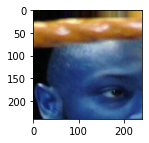

"b' Jay_Rock': 2.941%"

"b' Seun_Kuti': 1.005%"

"b' Marcus_Collins': 0.856%"

"b' B._J._Upton': 0.756%"

"b' John_Dumelo': 0.730%"

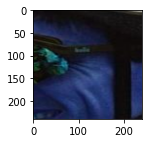

"b' Jewel_Mische': 0.364%"

"b' Mohit_Chauhan': 0.236%"

"b' Yolanda_Andrade': 0.193%"

"b' Nyusha': 0.147%"

"b' Layne_Staley': 0.125%"

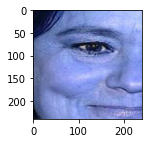

"b' Jasmin_Tabatabai': 2.474%"

"b' Leanne_Wood': 2.148%"

"b' Dira_Paes': 1.881%"

"b' Lena_Adelsohn_Liljeroth': 1.771%"

"b' Monica_Guerritore': 1.564%"

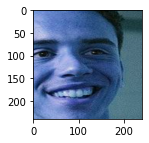

"b' Pedro_Su\\xc3\\xa1rez_V\\xc3\\xa9rtiz': 31.078%"

"b' Chad_le_Clos': 22.905%"

"b' Kris_Allen': 11.202%"

"b' Ibrahim_Afellay': 2.759%"

"b' Reimond_Manco': 2.460%"

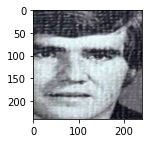

"b' Guillermo_Capetillo': 27.259%"

"b' Sa\\xc3\\xbal_Lisazo': 22.123%"

"b' Mark_Emmert': 8.346%"

"b' Samuel_Rosa': 5.481%"

"b' Roger_Federer': 3.533%"

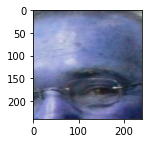

"b' Stephan_Weil': 3.923%"

"b' Stephen_Elop': 2.164%"

"b' Damir_Kajin': 1.642%"

"b' Herbert_Vianna': 0.990%"

"b' Larry_Holmes': 0.929%"

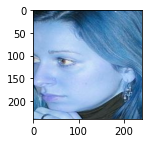

"b' Cintia_Dicker': 6.214%"

"b' Cara_Dillon': 4.041%"

"b' Sesil_Karatantcheva': 3.055%"

"b' Irene_Fornaciari': 2.055%"

"b' Selah_Sue': 2.043%"

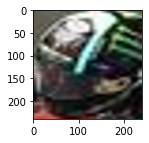

"b' Jermichael_Finley': 0.504%"

"b' Alexandre_Bilodeau': 0.250%"

"b' Mushfiqur_Rahim': 0.250%"

"b' Roberto_Heras': 0.219%"

"b' Vesna_Fabjan': 0.210%"

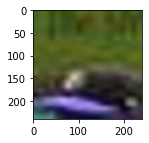

"b' Bob_Beckel': 0.968%"

"b' Semmy_Schilt': 0.617%"

"b' Mrisho_Ngasa': 0.535%"

"b' Natsumi_Matsubara': 0.432%"

"b' Jerry_Rawlings': 0.321%"

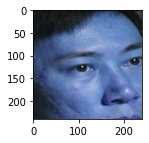

"b' Masaharu_Fukuyama': 10.060%"

"b' Sukrit_Wisetkaew': 6.841%"

"b' Go_Shiozaki': 3.546%"

"b' Louis_Koo': 2.947%"

"b' Gabby_Concepcion': 2.439%"

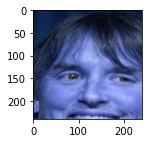

"b' Ronn_Moss': 8.741%"

"b' Donna_Leon': 8.186%"

"b' Jimi_Jamison': 6.011%"

"b' Julio_Iglesias_Jr.': 5.335%"

"b' Javier_Saviola': 2.803%"

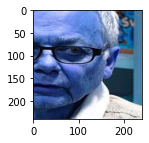

"b' Kurtwood_Smith': 16.274%"

"b' Martin_Sorrell': 11.773%"

"b' Hip\\xc3\\xb3lito_Mej\\xc3\\xada': 8.372%"

"b' Edgar_Savisaar': 5.654%"

"b' Jan_Bj\\xc3\\xb6rklund': 4.400%"

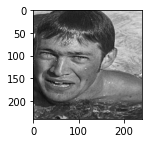

"b' Victor_Pi\\xc8\\x9burc\\xc4\\x83': 8.057%"

"b' Almazbek_Atambayev': 4.673%"

"b' Riccardo_Fogli': 4.157%"

"b' Julio_C\\xc3\\xa9sar_Falcioni': 2.700%"

"b' Don_The_Dragon_Wilson': 2.077%"

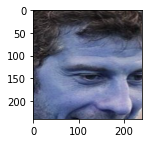

"b' Michael_Grylls': 4.283%"

"b' Carlos_Ocariz': 3.092%"

"b' Emre_Bel\\xc3\\xb6zo\\xc4\\x9flu': 2.626%"

"b' Greg_Giraldo': 2.526%"

"b' Frank_Rijkaard': 2.432%"

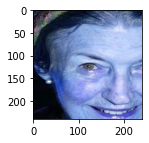

"b' Vesna_Pusi\\xc4\\x87': 35.296%"

"b' Irmelin_Indenbirken': 12.186%"

"b' Anna_Bligh': 5.123%"

"b' C\\xc3\\xa9cilia_Attias': 4.649%"

"b' Heike_Drechsler': 1.742%"

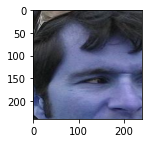

"b' Cody_Longo': 2.064%"

"b' Guillermo_Capetillo': 1.932%"

"b' Benoist_Apparu': 1.657%"

"b' Tomasz_Karolak': 1.327%"

"b' Samuel_Rosa': 1.310%"

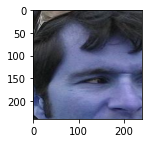

In [11]:
fig, ax = plt.subplots(figsize=(3,2))
for i in range(test_faces.shape[0]):
    face = test_faces[i]
    face_input = np.expand_dims(face,axis=0)
    yhat = face_model.predict(face_input)
    results = decode_predictions(yhat)
    ax.imshow(face)
    display(fig)
    for result in results[0]:
        display('%s: %.3f%%' % (result[0], result[1]*100))
    
    
    